In [1]:
# Data handling libraries
import pandas as pd
import numpy as np

# Install XGBoost
import xgboost

# Data collections
from collections import OrderedDict

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# filtering warnings
import warnings
warnings.filterwarnings("ignore")

# mulitcolinearity heck libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor

# data transformation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, learning_curve

# data evaluation libraries
from sklearn.metrics import r2_score,mean_squared_error

# machine learning model libraries
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor

# Clustering Libraries
from sklearn.cluster import KMeans

In [2]:
df=pd.read_excel("Capstone Project.xlsx")

In [3]:
df_copy = df

In [4]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [5]:
# finding descrpitive stats
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtype != object:
            stats = OrderedDict({
                "Feature Name" : col,
                "Count" : my_df[col].count(),
                "Minimum" : my_df[col].min(),
                "Quartile1" : my_df[col].quantile(0.25),
                "Mean" : my_df[col].mean(),
                "Median" : my_df[col].median(),
                "Quartile3" : my_df[col].quantile(0.75),
                "Maximum" : my_df[col].max(),
                "Variance" : my_df[col].var(),
                "Standard Deviation" : my_df[col].std(),
                "Skewness" : my_df[col].skew(),
                "Kurtosis" : my_df[col].kurt(),
                "IQR" : my_df[col].quantile(0.75)-my_df[col].quantile(0.25)
            })
            result.append(stats) 
    result_df = pd.DataFrame(result)
    
    ## Skewness type
    skew_type = []
    for i in result_df["Skewness"]:
        if i < -1:
            skew_type.append("Highly Negatively Skewed")
        elif -1 < i < -0.5:
            skew_type.append("Moderately Negatively Skewed")
        elif -0.5 < i < 0:
            skew_type.append("Fairly Negatively Skewed")
        elif 0 < i < 0.5:
            skew_type.append("Fairly Positively Skewed")
        elif 0.5 < i < 1:
            skew_type.append("Moderately positively Skewed")
        elif i > 1:
            skew_type.append("Highly Positively Skewed")
    result_df["Skewness Type"] = skew_type
    
    ## Kurtosis Type
    kurt_type = []
    for j in result_df["Kurtosis"]:
        if j >= 1:
            kurt_type.append("Leptokurtic")
        elif j <= -1:
            kurt_type.append("Platykurtic")
        else:
            kurt_type.append("Mesokurtic")
    result_df["Kurtosis Type"] = kurt_type
    
    #outliers
    upperlim=stats["Quartile3"]+1.5*stats["IQR"]
    lowerlim=stats["Quartile1"]-1.5*stats["IQR"]
    
    if len([x for x in my_df[col] if x < lowerlim or x > upperlim])>0:
        outlier_comment="Has outliers"
    else:
        outlier_comment="No outliers"
    
    result_df["outlier_comment"]=outlier_comment
    
    return result_df

In [6]:
custom_summary(df)

,Feature Name,Count,Minimum,Quartile1,Mean,Median,Quartile3,Maximum,Variance,Standard Deviation,Skewness,Kurtosis,IQR,Skewness Type,Kurtosis Type,outlier_comment
0,cement,1030,102.00,192.375,281.167864,272.900,350.000,540.0,10921.580220,104.506364,0.509481,-0.520652,157.625,Moderately positively Skewed,Mesokurtic,Has outliers
1,slag,1030,0.00,0.000,73.895825,22.000,142.950,359.4,7444.124812,86.279342,0.800717,-0.508175,142.950,Moderately positively Skewed,Mesokurtic,Has outliers
2,ash,1030,0.00,0.000,54.188350,0.000,118.300,200.1,4095.616541,63.997004,0.537354,-1.328746,118.300,Moderately positively Skewed,Platykurtic,Has outliers
3,water,1030,121.80,164.900,181.567282,185.000,192.000,247.0,456.002651,21.354219,0.074628,0.122082,27.100,Fairly Positively Skewed,Mesokurtic,Has outliers
4,superplastic,1030,0.00,0.000,6.204660,6.400,10.200,32.2,35.686781,5.973841,0.907203,1.411269,10.200,Moderately positively Skewed,Leptokurtic,Has outliers
5,coarseagg,1030,801.00,932.000,972.918932,968.000,1029.400,1145.0,6045.677357,77.753954,-0.040220,-0.599016,97.400,Fairly Negatively Skewed,Mesokurtic,Has outliers
6,fineagg,1030,594.00,730.950,773.580485,779.500,824.000,992.6,6428.187792,80.175980,-0.253010,-0.102177,93.050,Fairly Negatively Skewed,Mesokurtic,Has outliers
7,age,1030,1.00,7.000,45.662136,28.000,56.000,365.0,3990.437729,63.169912,3.269177,12.168989,49.000,Highly Positively Skewed,Leptokurtic,Has outliers
8,strength,1030,2.33,23.710,35.817961,34.445,46.135,82.6,279.081814,16.705742,0.416977,-0.313725,22.425,Fairly Positively Skewed,Mesokurtic,Has outliers


## Analysis of custom summary

* From the above analysis we can see that almost all the columns have outliers
* As all the columns have count of 1030, this implies that there are no null values
* There is no categorical data
* Age is the only column which is very highly skewed
* Slag ash and superplastic have no values till quartile 1
* Ash has no data till 50%
* As the max age is 365, it seems that its yearly data
* Mean is not good in ash

In [7]:
# treating outliers
 
def replace_outlier(df,col,method="Quartile",strategy="Median"):
    col_data=df[col]
    
    if method=="Quartile":
        q2=df[col].median()
        q1=df[col].quantile(0.25)
        q3=df[col].quantile(0.75)
        iqr=q3-q1
        lowerlim=q1-1.5*iqr
        upperlim=q3+1.5*iqr
        
    elif method=="Standard Deviation":
        col_mean=df[col].mean()
        col_std=df[col].std()
        lowerlim=col_mean-2*col_std
        upperlim=col_mean+2*col_std
        
    outliers=df.loc[(col_data<lowerlim)|(col_data>upperlim),col]
    outliers_density=len(outliers)/len(df)
    
    if len(outliers)==0:
        print(f"The {col} has no outliers")
    else:
        print(f"The {col} has outliers")
        print(f"Outlier density is ",outliers_density)
    
    
    if strategy=="Median":
        df.loc[(col_data<lowerlim)|(col_data>upperlim),col]=df[col].median()
    elif strategy=="Mean":
        df.loc[(col_data<lowerlim)|(col_data>upperlim),col]=df[col].mean()
    
    return df

 ### ODT plots
  in ODT we have 3 plots,
  1. Box plot
  2. Histogram (with outliers)
  3. Histogram (without outliers)

In [8]:
def odt_plots(df,col):
    f,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,20))
    
    # descriptive statistics using box plot
    sns.boxplot(df[col],ax=ax1)
    ax1.set_title(col+" box plot")
    ax1.set_xlabel("box plot")
    ax1.set_ylabel("values")
    
    #histogram with outliers
    sns.distplot(df[col],ax=ax2)
    ax1.set_title(col+" histogram with outliers")
    ax1.set_xlabel("density")
    ax1.set_ylabel("values")
    
    
    # histogram without outliers
    
    y=replace_outlier(df,col)
    sns.distplot(y[col],ax=ax3)
    ax1.set_title(col+" histogram without outliers")
    ax1.set_xlabel("density")
    ax1.set_ylabel("values")
    
    

The cement has no outliers
The slag has outliers
Outlier density is  0.001941747572815534
The ash has no outliers
The water has outliers
Outlier density is  0.008737864077669903
The superplastic has outliers
Outlier density is  0.009708737864077669
The coarseagg has no outliers
The fineagg has outliers
Outlier density is  0.0048543689320388345
The age has outliers
Outlier density is  0.05728155339805825
The strength has outliers
Outlier density is  0.003883495145631068


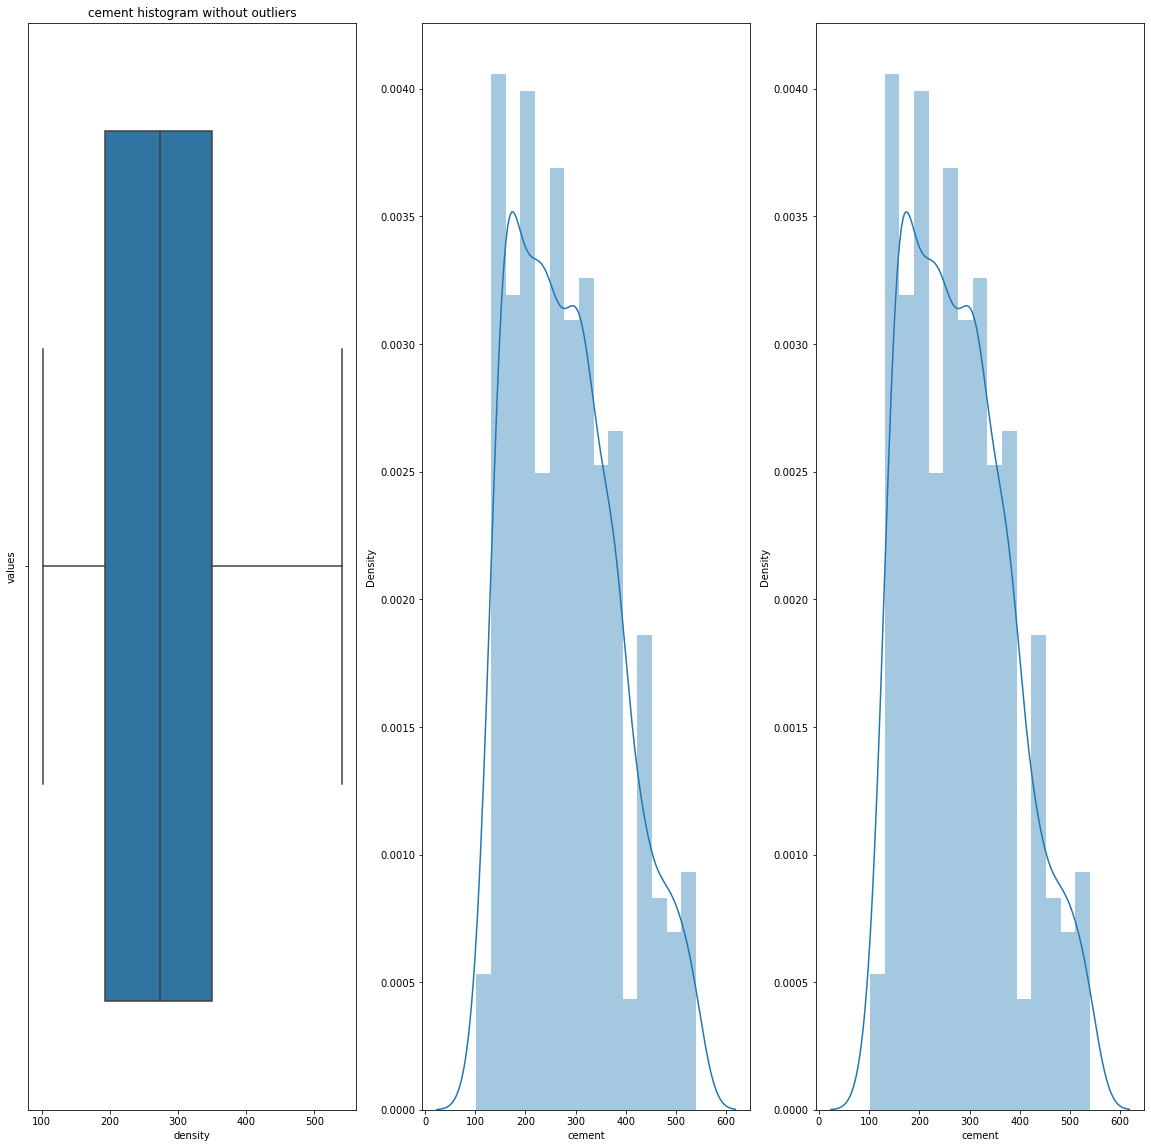

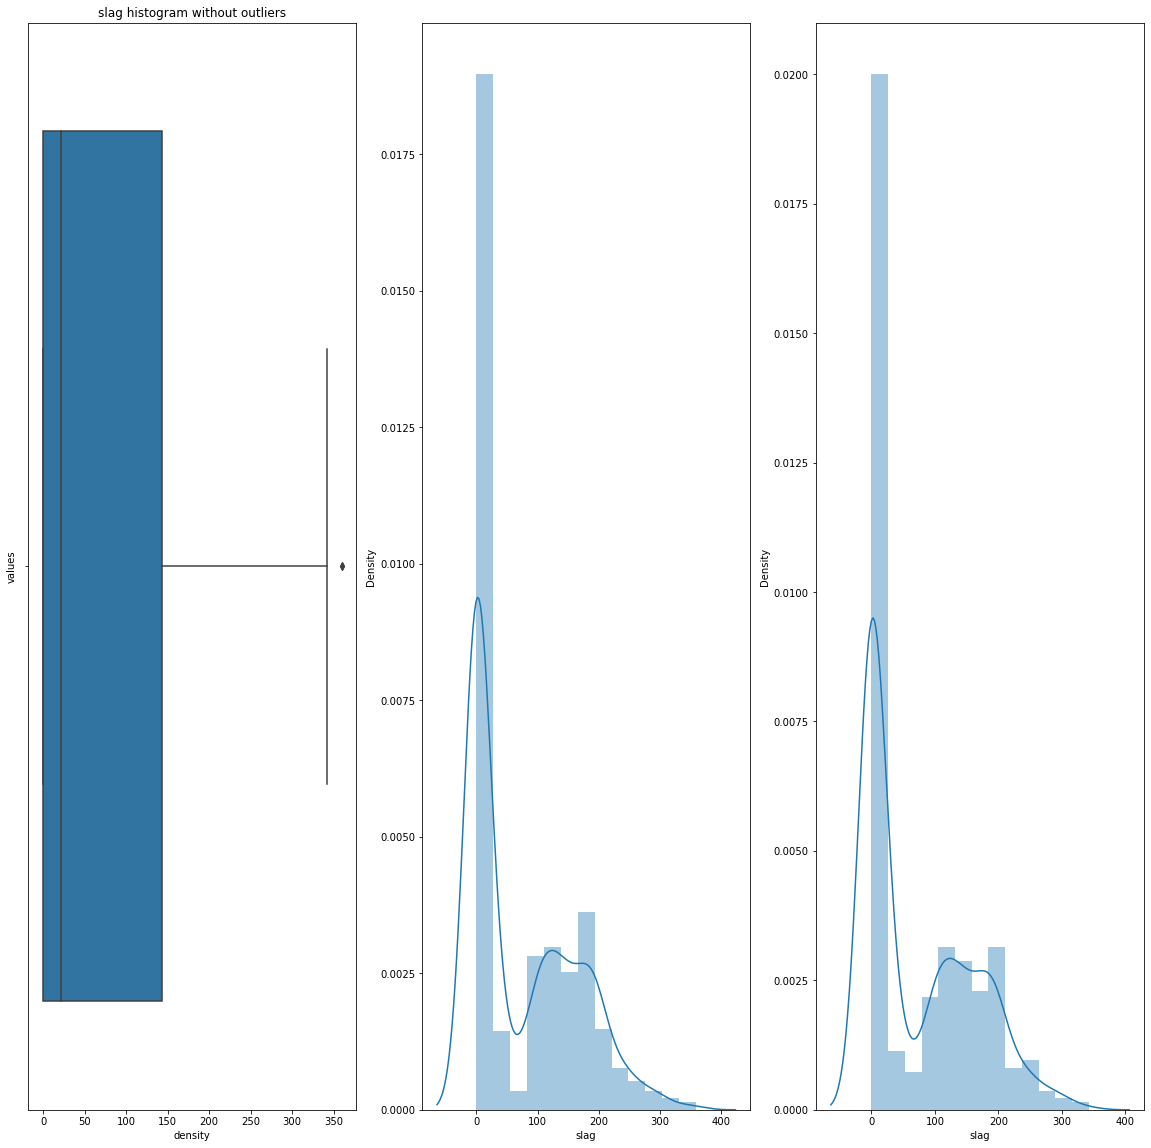

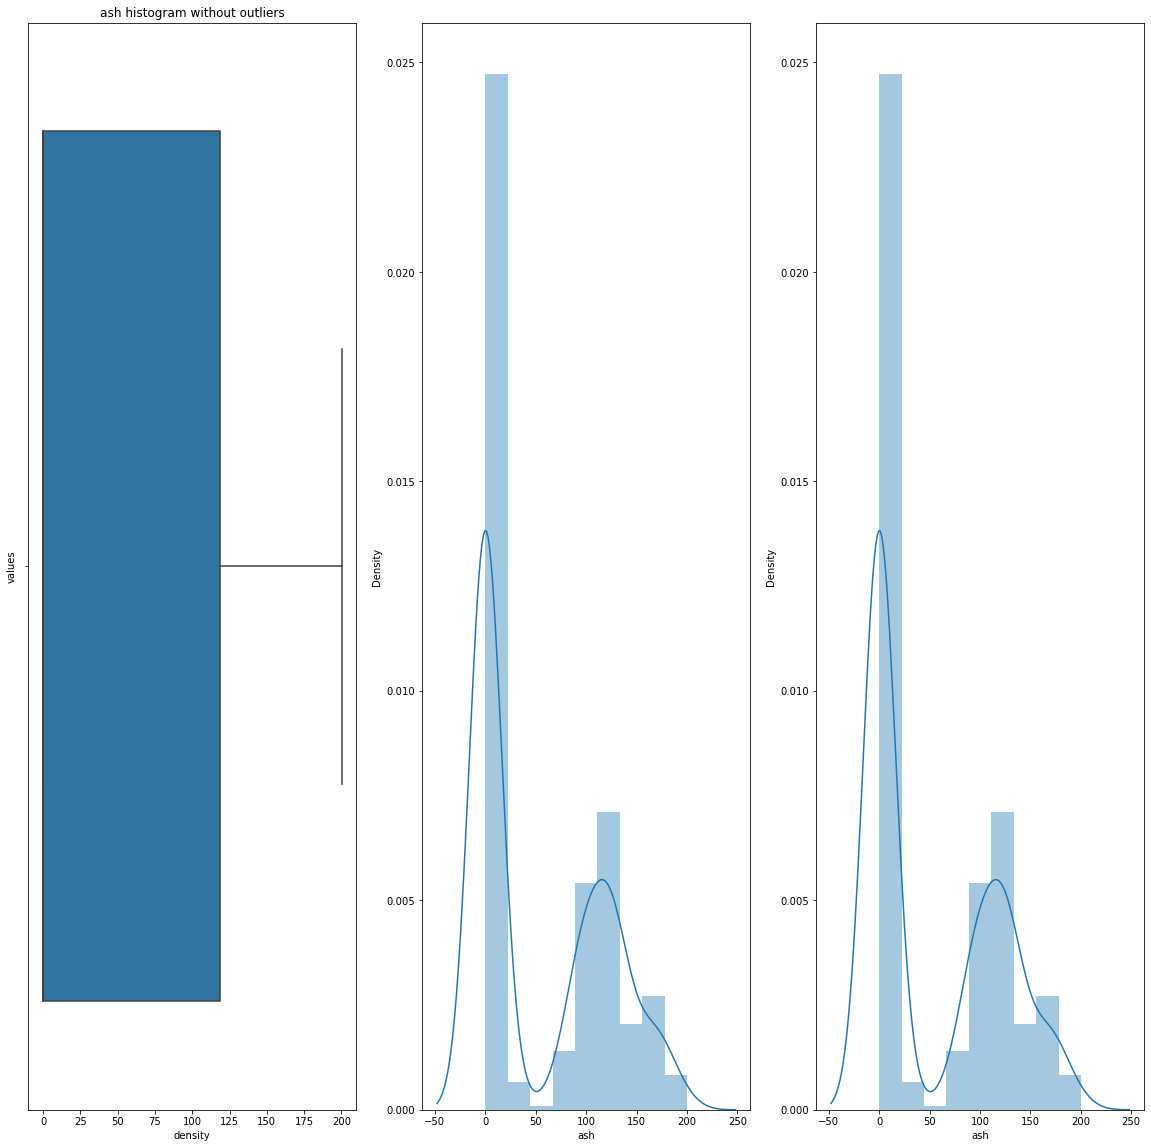

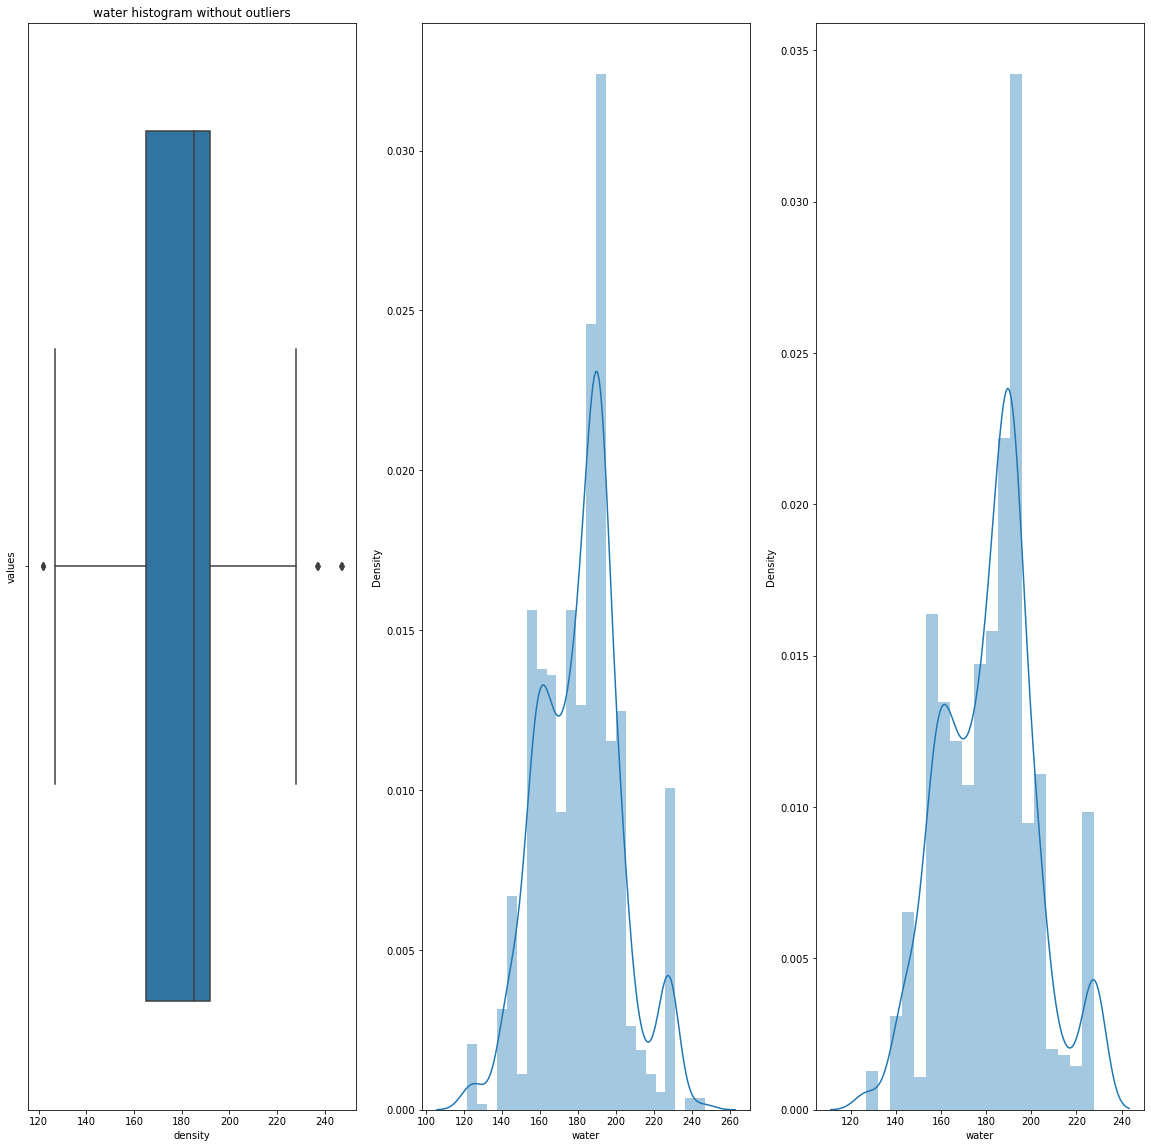

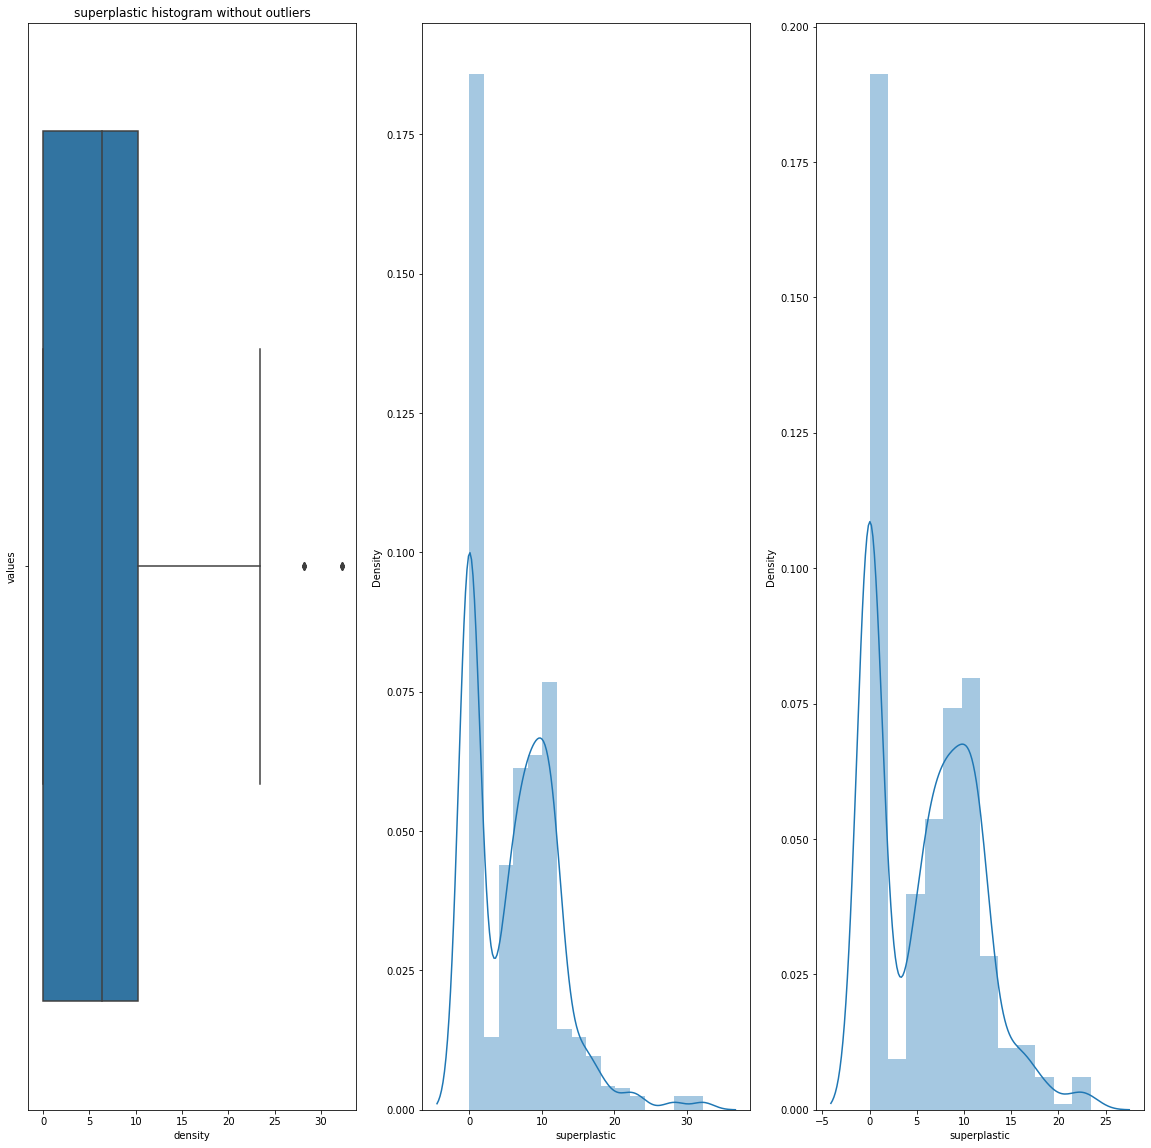

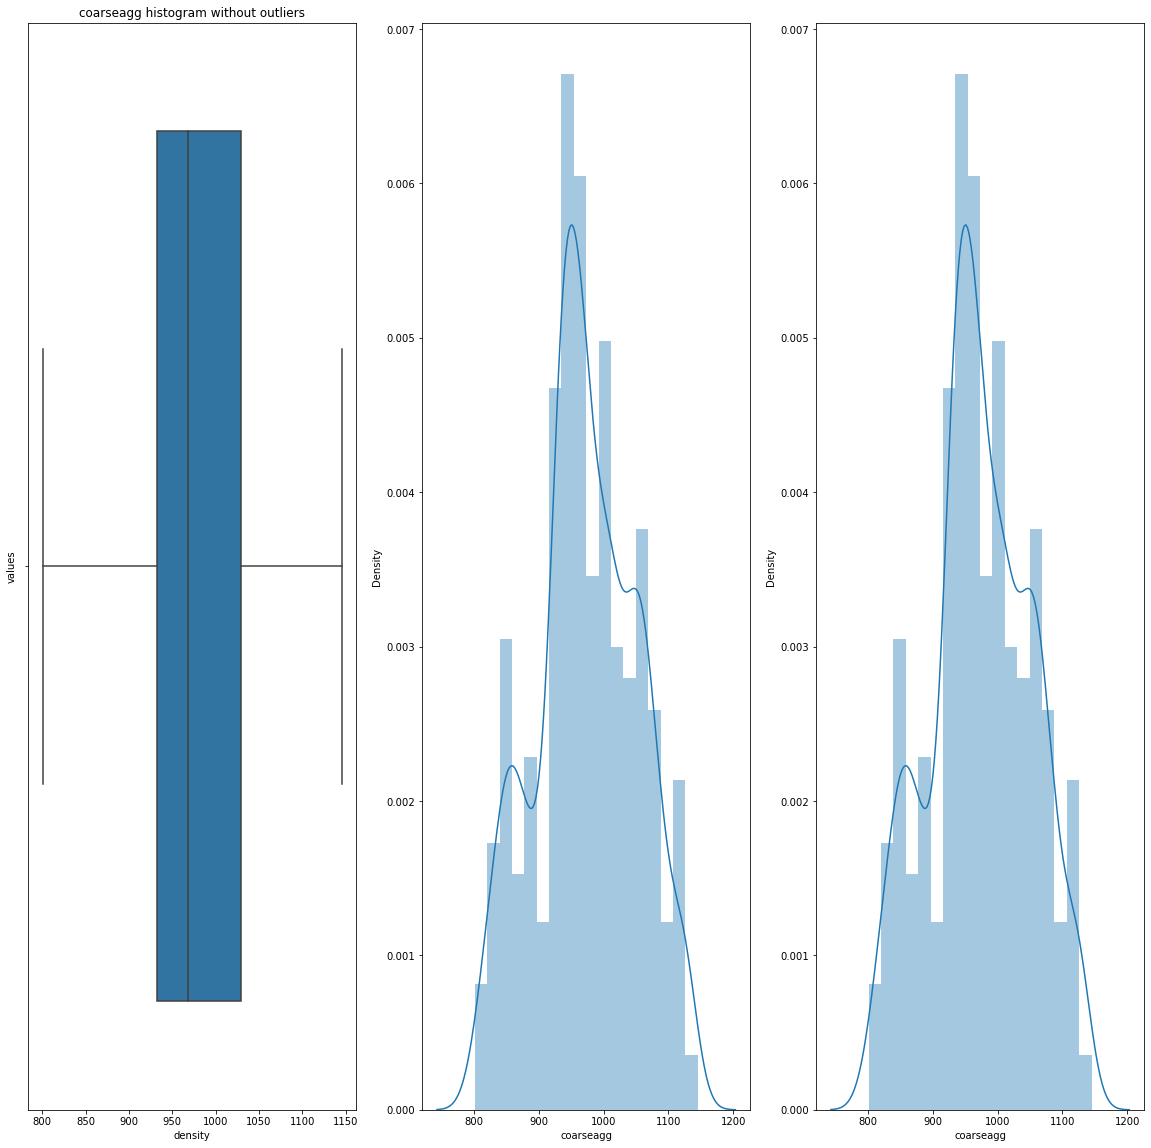

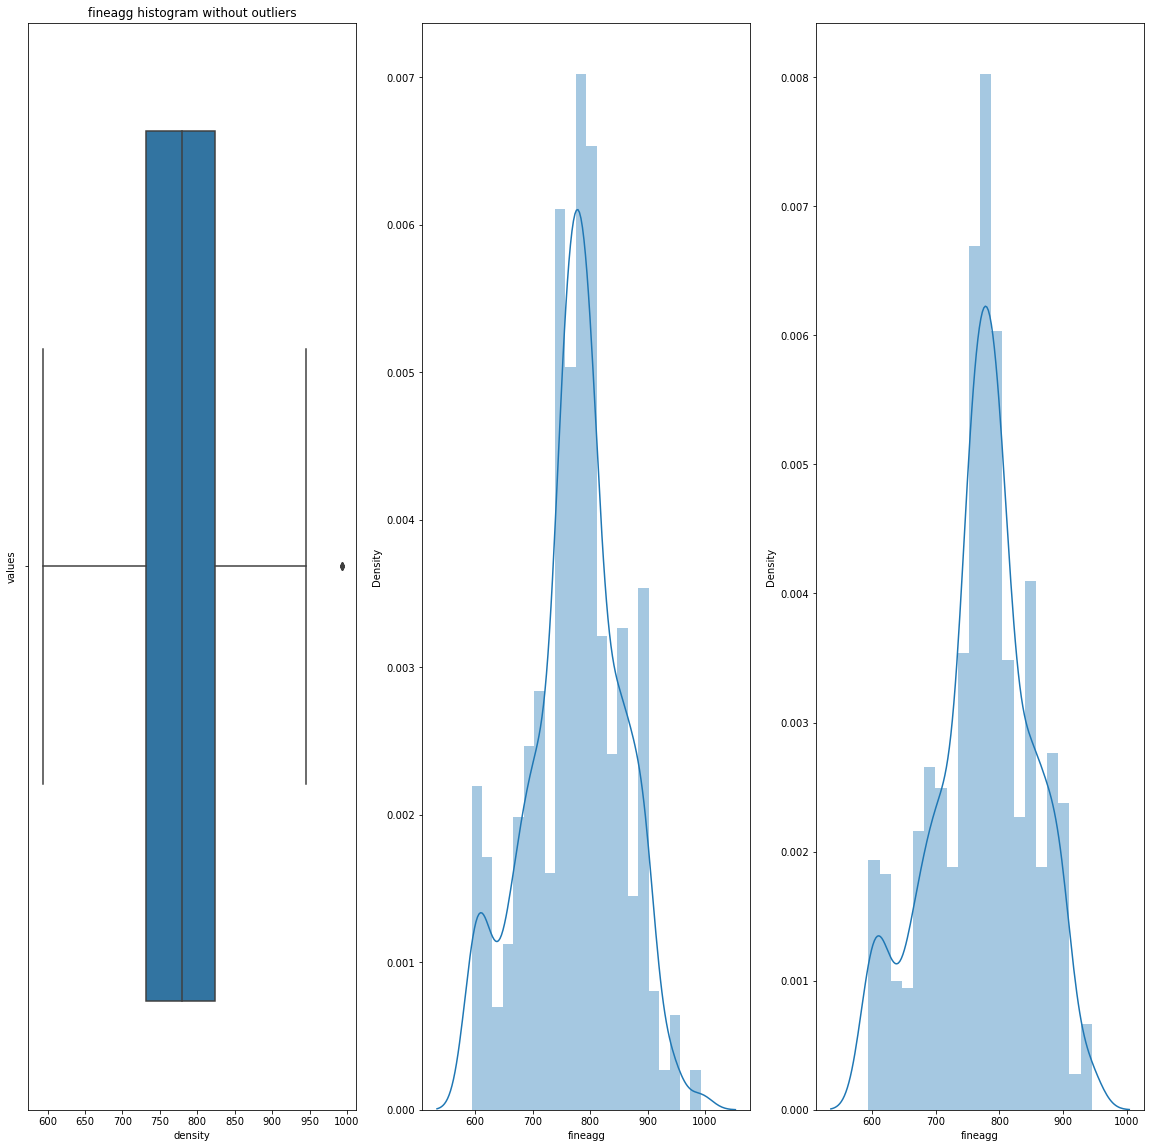

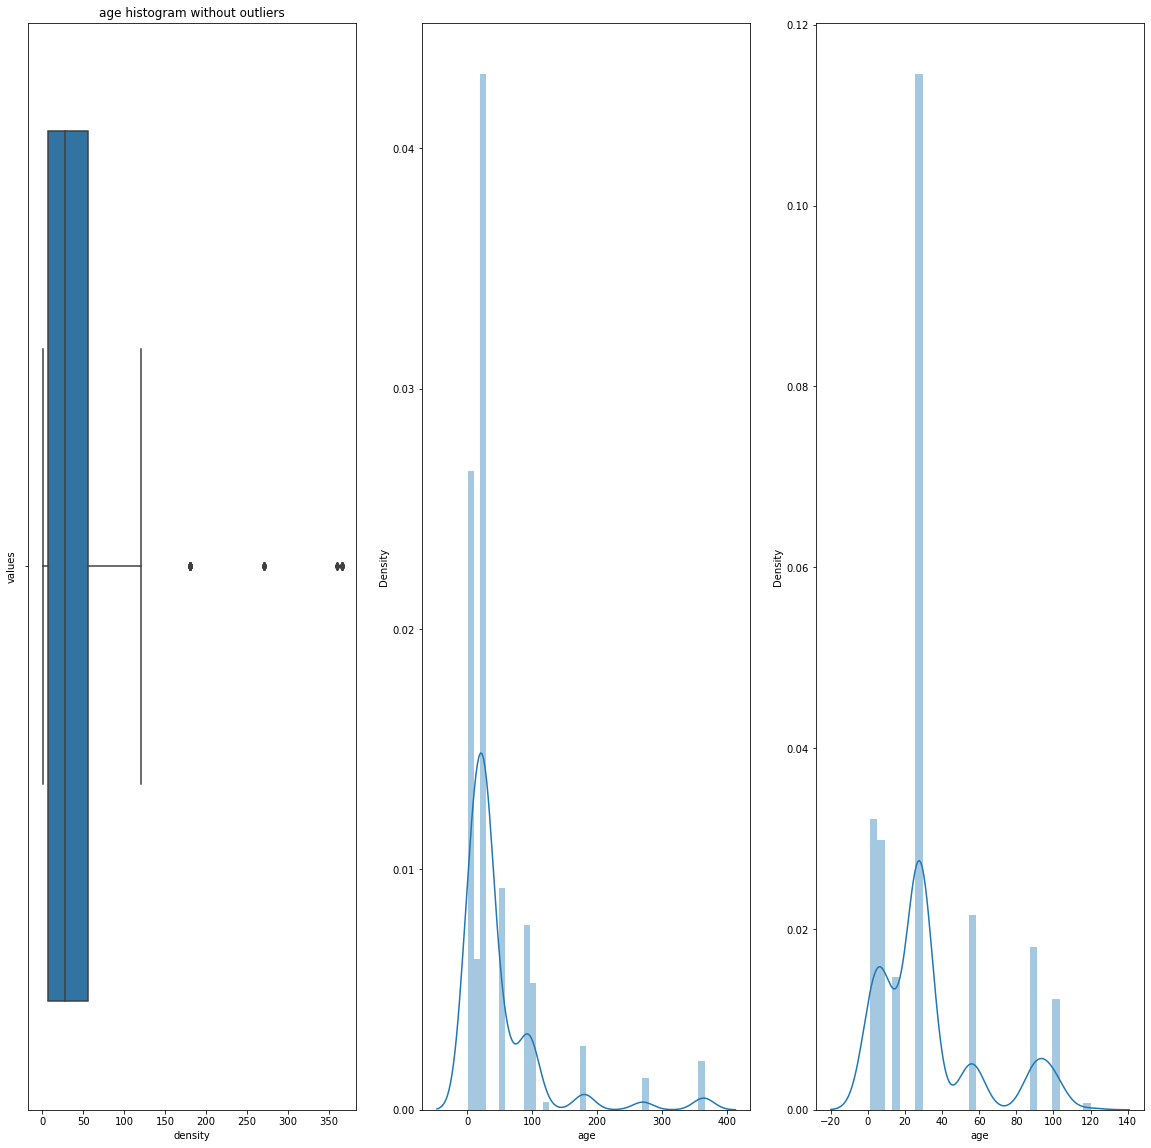

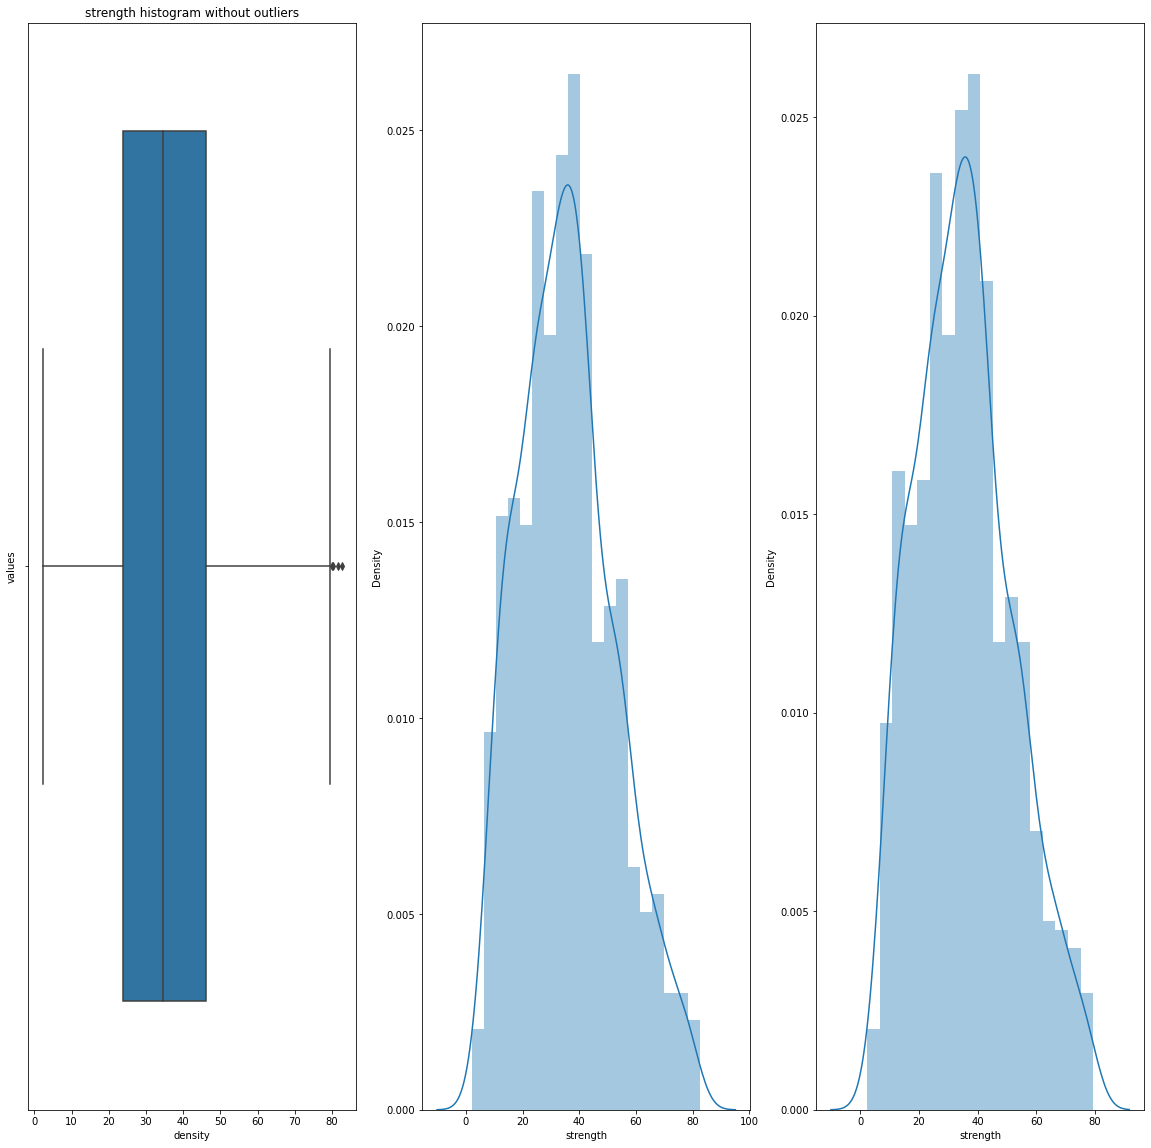

In [9]:
for col in df.columns:
    odt_plots(df,col)

#### Mutli variate relationship analysis

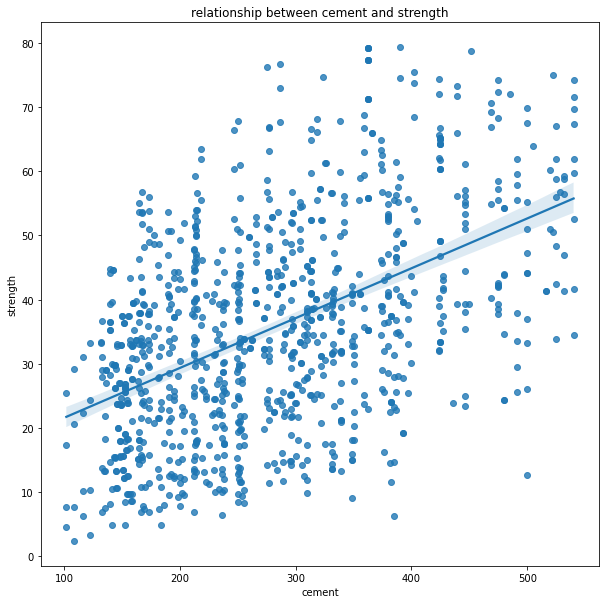

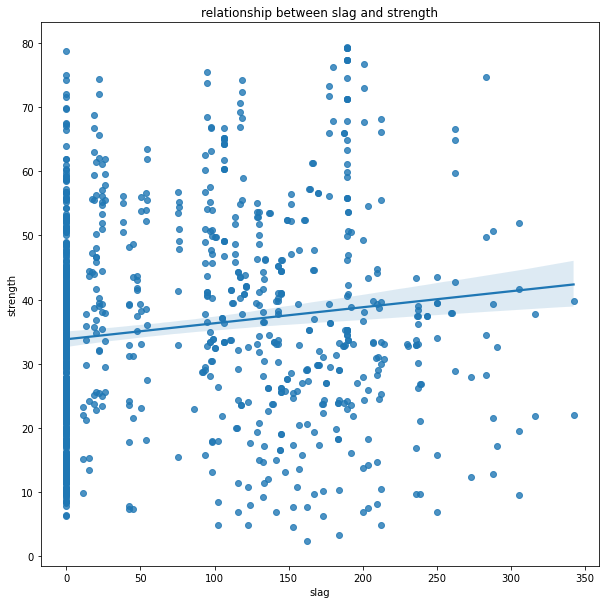

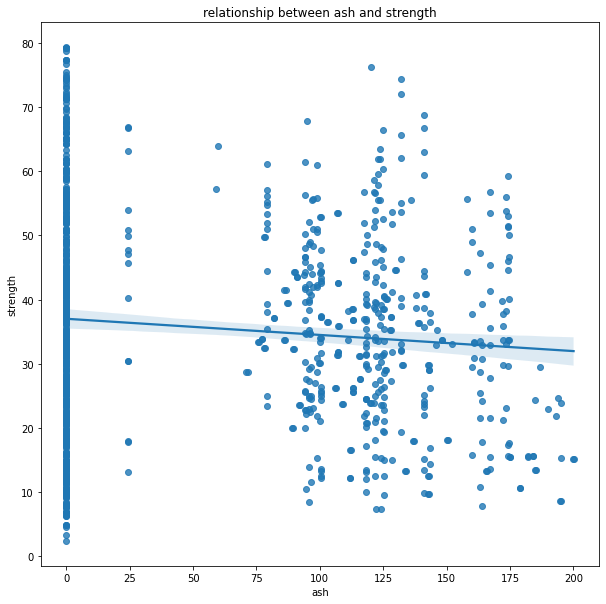

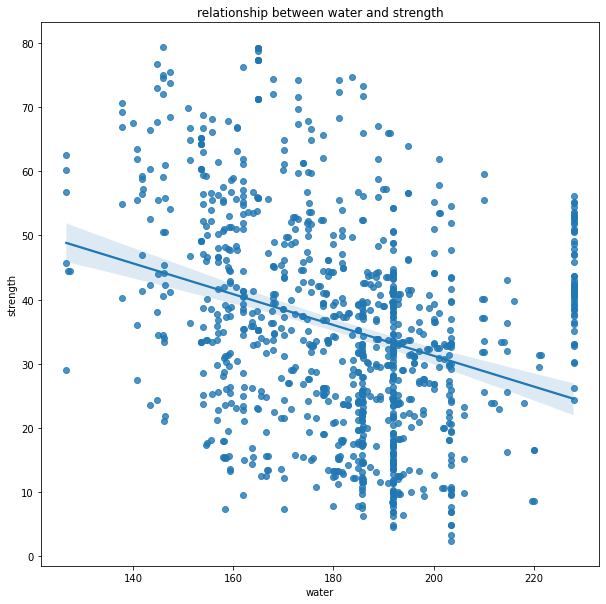

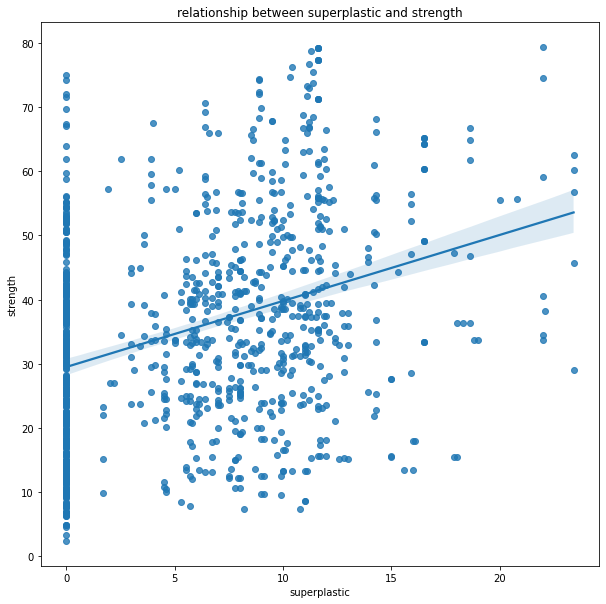

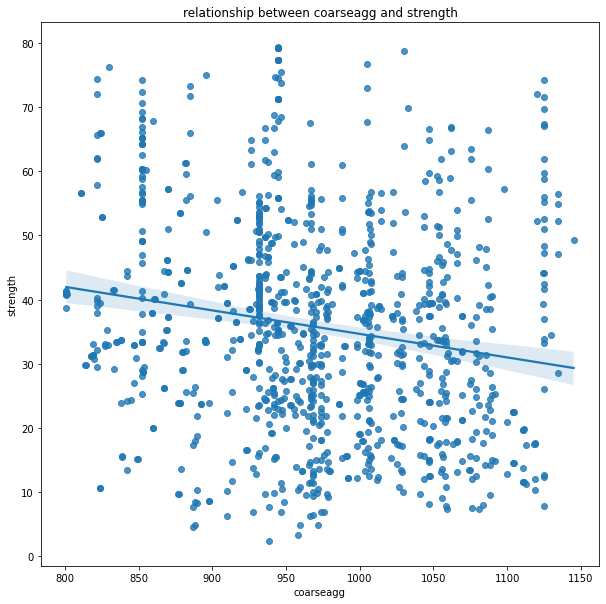

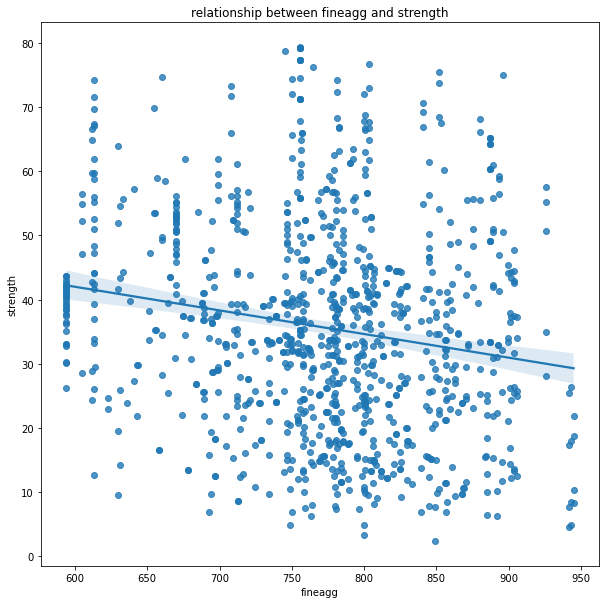

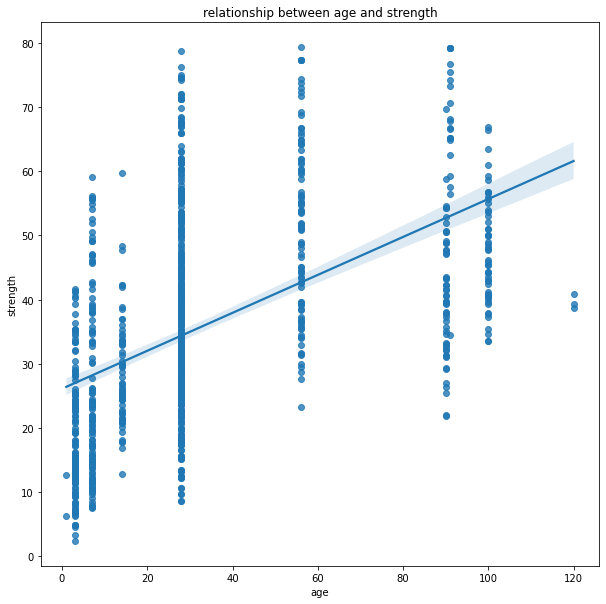

In [10]:
for col in df.columns:
    if col!="strength":
        f,ax1=plt.subplots(figsize=(10,10))
        sns.regplot(x=df[col],y=df["strength"],ax=ax1)
        ax1.set_title(f"relationship between {col} and strength")

###### Points of analysis:
 1. cement and strength are having a high positive correlation
 2. slag and strength are having positive correlation
 3. ash and strength are having a low negative correlation
 4. water and strength are having high negative correlation
 5. superplastic and strength are having a high positive correlation
 6. coarseagg and strength are having moderate negative correlation
 7. fineagg and strength are having moderate negative correaltion
 8. age and strength are having a high positive correlation

In [11]:
def corr_target(df,target):
    ind_var=df.drop(target,axis=1).columns
    corr_result=[]
    for col in ind_var:
        corr_result.append(df[target].corr(df[col]))
        
    result_df=pd.DataFrame([ind_var,corr_result],index=["variable","correlation"]).T
    
    return result_df.sort_values("correlation",ascending=False)

In [12]:
corr_target(df,"strength")

,variable,correlation
7,age,0.499711
0,cement,0.493518
4,superplastic,0.342633
1,slag,0.129561
2,ash,-0.097973
5,coarseagg,-0.173234
6,fineagg,-0.176113
3,water,-0.300043


###### Correlation analysis:  
age > cement > superplastic > water > fineagg > coarseagg > slag > ash

## Checking MultiColinearity

<AxesSubplot:>

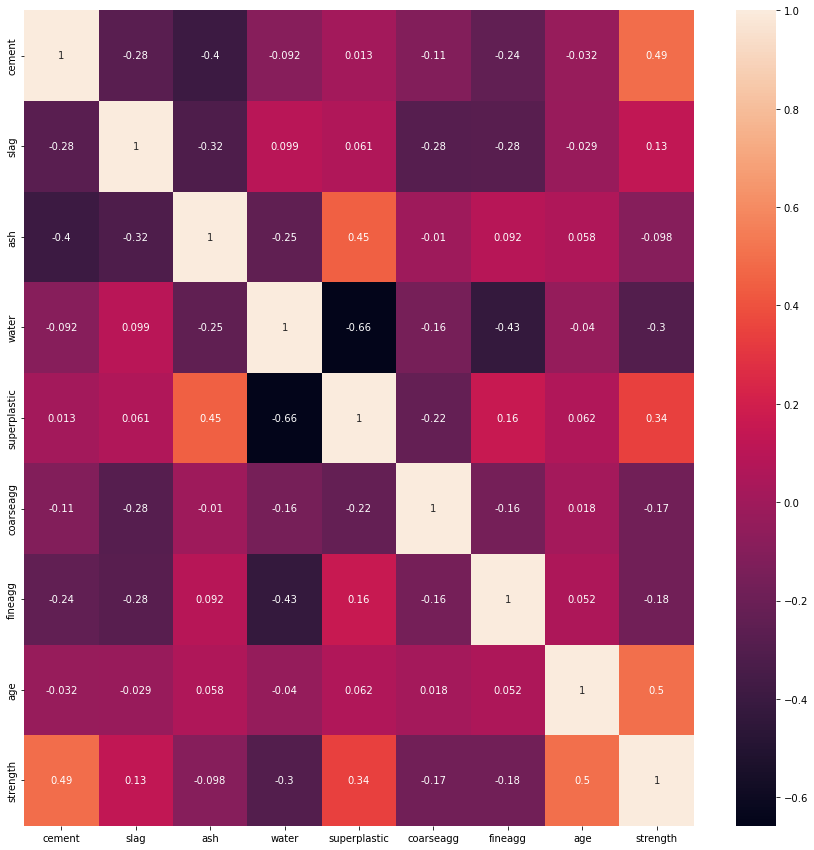

In [13]:
corr=df.corr()
f,ax=plt.subplots(figsize=(15,15))
sns.heatmap(corr,annot=True)

### Heatmap analysis

1. slag and ash are having multi-colinearity of 32%
2. ash and superplastic are having multi-colinearity of 66%
3. cement and ash are having multi-colinearity of 40%
4. water and fineagg are having multi-colinearity of 43%
5. water and superplastic are having multi-colinearity of 66%
6. slag and ash are having multi-colinearity of 32%

#### VIF
* It stands for Varianec Inflation Factor
* In VIF we regress each independent variable with all other and find out the r2 score
* The formula for VIF is VIF = 1 / ( 1 - r2_score )
* If VIF is more than 5 then we say than multicolinearity exists

In [14]:
def vif_test(ind_var):
    result_df=pd.DataFrame()
    result_df["feature"]=ind_var.columns
    result_df["Vif_factor"]=[variance_inflation_factor(ind_var.values,i) for i in range(ind_var.shape[1])]
    return result_df.sort_values("Vif_factor",ascending=False)

In [15]:
vif_test(df.drop("strength",axis=1))

,feature,Vif_factor
5,coarseagg,86.938582
3,water,81.963087
6,fineagg,68.664404
0,cement,14.291158
4,superplastic,5.724145
2,ash,4.415840
1,slag,3.342314
7,age,2.368372


In [16]:
# from the above vif we can conclude that we are having very high multi-colinearity, so to remove this multi-colinearity we have to perform PCA.

#### PCA
 * step-1 : Do feature scaling
 * step-2 : Apply PCA

In [17]:
def apply_pca(x):
    n_comp=len(x.columns)
    
    # applying feature scaling
    x=StandardScaler().fit_transform(x)
    
    # applying PCA
    for i in range(1,n_comp):
        pca=PCA(n_components=i)
        p_components=pca.fit_transform(x)
        
        evr=np.cumsum(pca.explained_variance_ratio_)
        if evr[i-1]>0.9:
            n_components=i
            break
            
    print("Explained Variance Ratio is ",evr)
    
    # creating a dataframe
    col=[]
    for j in range(1,n_components+1):
        col.append("pc_"+str(j))
    
    
    result_df=pd.DataFrame(data=p_components,columns=col)
    
    return result_df

In [18]:
x=df.drop(["strength"],axis=1)
y=df[["strength"]]

In [19]:
pca_df=apply_pca(x)

Explained Variance Ratio is  [0.27112429 0.44666571 0.60914114 0.73584634 0.85926016 0.97264602]


In [20]:
pca_df

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228
...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321


In [21]:
vif_test(pca_df)

,feature,Vif_factor
2,pc_3,1.0
1,pc_2,1.0
5,pc_6,1.0
0,pc_1,1.0
3,pc_4,1.0
4,pc_5,1.0


In [22]:
pca_df=pca_df.join(y,how="left")

In [23]:
pca_df

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,strength
0,1.810919,1.331664,-1.284484,-0.306148,-0.067652,-0.886110,29.89
1,-1.823833,-0.573436,-1.058973,0.893130,-0.913984,-0.751061,23.51
2,-0.739819,-0.463200,-0.541643,-1.033210,-0.308068,0.611045,29.22
3,2.766368,0.602978,-0.512532,0.008806,0.086415,0.850548,45.85
4,0.892523,0.966627,-0.863624,1.148561,-0.064439,-1.221228,18.29
...,...,...,...,...,...,...,...
1025,-1.743036,0.071059,-1.492203,0.045227,-0.449481,0.968953,13.29
1026,-1.079147,-0.572265,3.269799,-1.669125,-0.962953,0.002303,41.30
1027,-0.494143,1.276989,0.318398,-0.053272,-0.153787,0.751019,44.28
1028,2.688411,-0.236744,0.056551,-0.088955,0.105206,1.368321,55.06


## Model Building

* Normal model building
* Cross validation
* Hyperparameter tuning

In [24]:
x=pca_df.drop("strength",axis=1)
y=pca_df[["strength"]]

In [25]:
def train_and_test_split(x,y,test_size=0.3):
    return train_test_split(x,y,test_size=test_size,random_state=42)

In [26]:
def build_model(x,y,estimator,model_name):
    x_train,x_test,y_train,y_test=train_test_split(x,y)
    estimator.fit(x_train,y_train)
    y_pred=estimator.predict(x_test)
    r2score=r2_score(y_test,y_pred)
    rmse=np.sqrt(mean_squared_error(y_test,y_pred))
    temp=[model_name,r2score,rmse]
    return temp

In [27]:
build_model(x,y,LinearRegression(),"Linear Regression")

['Linear Regression', 0.6559016505776447, 9.737512930869437]

In [28]:
def multiple_model(x,y):
    col=["model_name","r2 score","rmse"]
    
    result_df=pd.DataFrame(columns=col)
    result_df.loc[len(result_df)]=build_model(x,y,LinearRegression(),"Linear Regression")
    result_df.loc[len(result_df)]=build_model(x,y,Lasso(),"Lasso Regression")
    result_df.loc[len(result_df)]=build_model(x,y,Ridge(),"Ridge Regression")
    result_df.loc[len(result_df)]=build_model(x,y,DecisionTreeRegressor(),"Decision Tree Regression")
    result_df.loc[len(result_df)]=build_model(x,y,KNeighborsRegressor(),"K Nearest Regression")
    result_df.loc[len(result_df)]=build_model(x,y,SVR(),"SVR")
    result_df.loc[len(result_df)]=build_model(x,y,AdaBoostRegressor(),"Ada Boost Regressor")
    result_df.loc[len(result_df)]=build_model(x,y,GradientBoostingRegressor(),"G Boost Regressor")
    result_df.loc[len(result_df)]=build_model(x,y,XGBRegressor(),"XG Boost Regressor")
    result_df.loc[len(result_df)]=build_model(x,y,RandomForestRegressor(),"Random Forest Regressor")
    
    return result_df

In [29]:
multiple_model(x,y)

,model_name,r2 score,rmse
0,Linear Regression,0.633512,9.901471
1,Lasso Regression,0.655110,9.340823
2,Ridge Regression,0.662501,10.197863
3,Decision Tree Regression,0.779188,7.979955
4,K Nearest Regression,0.771683,7.862355
5,SVR,0.700149,9.267412
6,Ada Boost Regressor,0.722744,8.764430
7,G Boost Regressor,0.840331,6.466499
8,XG Boost Regressor,0.808805,6.969786
9,Random Forest Regressor,0.831525,6.703309


### Cross validation

In [30]:
def cross_validation(x,y,fold=10):
    
    score_lr=cross_val_score(LinearRegression(),x,y,cv=fold)
    score_la=cross_val_score(Lasso(),x,y,cv=fold)
    score_rd=cross_val_score(Ridge(),x,y,cv=fold)
    score_dtr=cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_knr=cross_val_score(KNeighborsRegressor(),x,y,cv=fold)
    score_svr=cross_val_score(SVR(),x,y,cv=fold)
    score_abr=cross_val_score(AdaBoostRegressor(),x,y,cv=fold)
    score_gbr=cross_val_score(GradientBoostingRegressor(),x,y,cv=fold)
    score_xgr=cross_val_score(XGBRegressor(),x,y,cv=fold)
    score_rfr=cross_val_score(RandomForestRegressor(),x,y,cv=fold)
    
    scores=[score_lr,score_la,score_rd,score_dtr,score_knr,score_svr,score_abr,score_gbr,score_xgr,score_rfr]
    model_names=["Linear Regression","Lasso","Ridge","Decision Tree Regressor","K nearest regressor","svr","ada boost regressor","G boost regressor","XGboost regressor","Random forest regressor"]
    
    result=[]
    for i in range(0,len(model_names)):
        score_mean=np.mean(scores[i])
        score_sd=np.std(scores[i])
        model_name=model_names[i]
        temp=[model_name,score_mean,score_sd]
        result.append(temp)
        
    result_df=pd.DataFrame(result,columns=["Model Name","Score mean","Score SD"])
    return result_df.sort_values("Score mean",ascending=False)

In [31]:
cross_validation(x,y)

,Model Name,Score mean,Score SD
8,XGboost regressor,0.873262,0.036061
9,Random forest regressor,0.868249,0.034297
7,G boost regressor,0.829126,0.050490
4,K nearest regressor,0.767856,0.055789
3,Decision Tree Regressor,0.756252,0.059909
6,ada boost regressor,0.729229,0.038478
5,svr,0.703117,0.042765
2,Ridge,0.663935,0.059437
0,Linear Regression,0.663928,0.059476
1,Lasso,0.649837,0.049887


#### Hyper parameter tuning

In [32]:
def hyper_parameter_tuning(x,y,fold=10):
    
    param_lass={"alpha":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_rd={"alpha":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_rfr={"n_estimators":[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]}
    param_knr={'n_neighbors':[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250]}
    param_adr={"n_estimators":[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250],"learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_gbr={"n_estimators":[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250],"learning_rate":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    param_xgb={'gamma': [0.5, 1, 1.5, 2, 5],'reg_lambda':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
    
    tuned_lass=GridSearchCV(Lasso(),param_lass,cv=fold)
    tuned_rd=GridSearchCV(Ridge(),param_rd,cv=fold)
    tuned_rfr=GridSearchCV(RandomForestRegressor(),param_rfr,cv=fold)
    tuned_knr=GridSearchCV(KNeighborsRegressor(),param_knr,cv=fold)
    tuned_adr=GridSearchCV(AdaBoostRegressor(),param_adr,cv=fold)
    tuned_gbr=GridSearchCV(GradientBoostingRegressor(),param_gbr,cv=fold)
    tuned_xgb=GridSearchCV(XGBRegressor(),param_xgb,cv=fold)
    
    tuned_lass.fit(x,y)
    tuned_rd.fit(x,y)
    tuned_rfr.fit(x,y)
    tuned_knr.fit(x,y)
    tuned_adr.fit(x,y)
    tuned_gbr.fit(x,y)
    tuned_xgb.fit(x,y)
    
    model=["Lasso","Ridge","Random forest regressor","K nearest regressor","Adaboost regressor","G boost regressor","XGboost regressor"]
    
    tuned=[tuned_lass,tuned_rd,tuned_rfr,tuned_knr,tuned_adr,tuned_gbr,tuned_xgb]
    
    for i in range(0,len(tuned)):
        print("Model",model[i])
        print("Best params",tuned[i].best_params_)

In [33]:
# hyper_parameter_tuning(x,y)

In [34]:
def cross_validation_tuned(x,y,fold=10):
    
    score_lr=cross_val_score(LinearRegression(),x,y,cv=fold)
    score_la=cross_val_score(Lasso(alpha=0.1),x,y,cv=fold)
    score_rd=cross_val_score(Ridge(alpha=1),x,y,cv=fold)
    score_dtr=cross_val_score(DecisionTreeRegressor(),x,y,cv=fold)
    score_knr=cross_val_score(KNeighborsRegressor(n_neighbors=10),x,y,cv=fold)
    score_svr=cross_val_score(SVR(),x,y,cv=fold)
    score_abr=cross_val_score(AdaBoostRegressor(learning_rate=0.7,n_estimators=70),x,y,cv=fold)
    score_gbr=cross_val_score(GradientBoostingRegressor(learning_rate=0.3,n_estimators=250),x,y,cv=fold)
    score_xgr=cross_val_score(XGBRegressor(gamma=1,learning_rate=0.2,reg_lambda=0.2),x,y,cv=fold)
    score_rfr=cross_val_score(RandomForestRegressor(n_estimators=170),x,y,cv=fold)
    
    scores=[score_lr,score_la,score_rd,score_dtr,score_knr,score_svr,score_abr,score_gbr,score_xgr,score_rfr]
    model_names=["Linear Regression","Lasso","Ridge","Decision Tree Regressor","K nearest regressor","svr","ada boost regressor","G boost regressor","XGboost regressor","Random forest regressor"]
    
    result=[]
    for i in range(0,len(model_names)):
        score_mean=np.mean(scores[i])
        score_sd=np.std(scores[i])
        model_name=model_names[i]
        temp=[model_name,score_mean,score_sd]
        result.append(temp)
        
    result_df=pd.DataFrame(result,columns=["Model Name","Score mean","Score SD"])
    return result_df.sort_values("Score mean",ascending=False)

In [35]:
cross_validation_tuned(x,y)

,Model Name,Score mean,Score SD
8,XGboost regressor,0.877223,0.034626
7,G boost regressor,0.867850,0.043905
9,Random forest regressor,0.866819,0.033262
3,Decision Tree Regressor,0.778364,0.054853
4,K nearest regressor,0.737413,0.060910
6,ada boost regressor,0.730564,0.036624
5,svr,0.703117,0.042765
1,Lasso,0.664143,0.058426
2,Ridge,0.663935,0.059437
0,Linear Regression,0.663928,0.059476


## Clustering

In [36]:
x=df_copy.drop(['strength'], axis=1)
y= df_copy[['strength']]

In [37]:
# Checking if clustering can help us to improve the accuracy even more
labels = KMeans(n_clusters=2, random_state=100).fit_predict(x)

<AxesSubplot:xlabel='cement', ylabel='strength'>

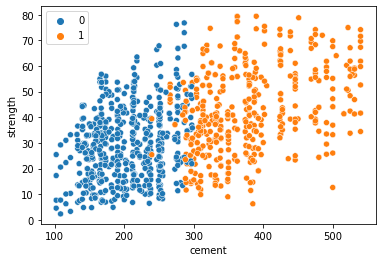

In [38]:
sns.scatterplot(x.cement, y.strength, hue=labels)  ## Cement is having a cluster with strength at a thresold of 300

<AxesSubplot:xlabel='slag', ylabel='strength'>

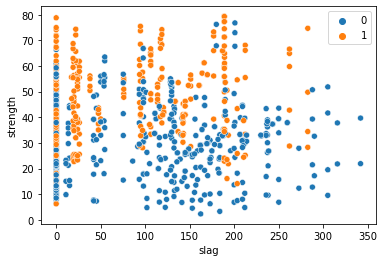

In [39]:
sns.scatterplot(x.slag, y.strength, hue=labels)  ## Slag is having no cluster

<AxesSubplot:xlabel='ash', ylabel='strength'>

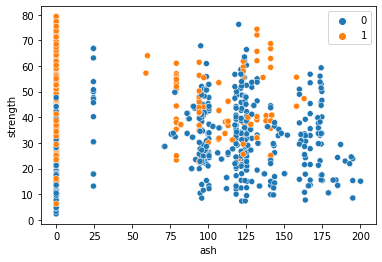

In [40]:
sns.scatterplot(x.ash, y.strength, hue=labels)  ## Ash is having no cluster

<AxesSubplot:xlabel='superplastic', ylabel='strength'>

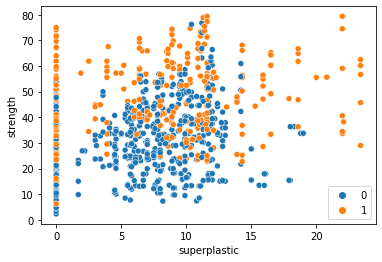

In [41]:
sns.scatterplot(x.superplastic, y.strength, hue=labels)  ## Superplastic is having no cluster

<AxesSubplot:xlabel='coarseagg', ylabel='strength'>

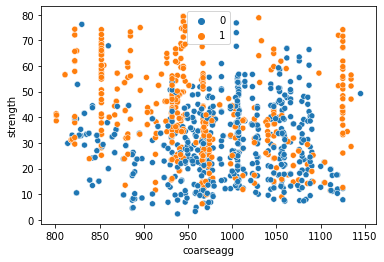

In [42]:
sns.scatterplot(x.coarseagg, y.strength, hue=labels) ## Coarseagg is having no cluster

<AxesSubplot:xlabel='fineagg', ylabel='strength'>

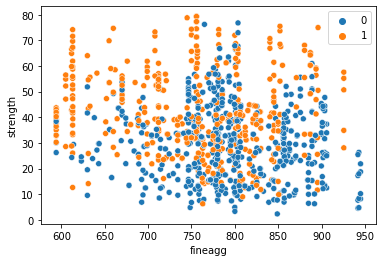

In [43]:
sns.scatterplot(x.fineagg, y.strength, hue=labels) ## Fineeagg is having no cluster

<AxesSubplot:xlabel='age', ylabel='strength'>

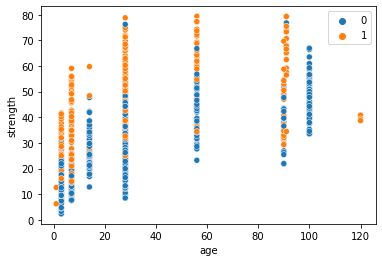

In [44]:
sns.scatterplot(x.age, y.strength, hue=labels)  ## Age is having no cluster

In [45]:
labels

array([0, 0, 0, ..., 0, 1, 1])

In [46]:
labels_df = pd.DataFrame(labels, columns=['labels'])

In [47]:
new_df = df_copy.join(labels_df, how='left')

In [48]:
new_df

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,labels
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89,0
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51,0
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22,0
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85,1
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29,0
...,...,...,...,...,...,...,...,...,...,...
1025,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29,0
1026,531.3,0.0,0.0,141.8,6.4,852.1,893.7,3,41.30,1
1027,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
1028,342.0,38.0,0.0,228.0,0.0,932.0,670.0,28,55.06,1


In [49]:
x = new_df.drop(['strength'], axis=1)
y= new_df[['strength']]

In [50]:
multiple_model(x,y)

,model_name,r2 score,rmse
0,Linear Regression,0.705469,9.156399
1,Lasso Regression,0.748311,8.769253
2,Ridge Regression,0.708763,8.740143
3,Decision Tree Regression,0.811739,6.981808
4,K Nearest Regression,0.628043,9.973619
5,SVR,0.217027,14.186160
6,Ada Boost Regressor,0.757459,8.311088
7,G Boost Regressor,0.900416,4.857041
8,XG Boost Regressor,0.909373,5.091931
9,Random Forest Regressor,0.910832,4.944352


In [51]:
cross_validation(x,y,fold=10)

,Model Name,Score mean,Score SD
8,XGboost regressor,0.899436,0.046856
9,Random forest regressor,0.886556,0.036432
7,G boost regressor,0.875849,0.044942
3,Decision Tree Regressor,0.834354,0.055712
6,ada boost regressor,0.744260,0.037813
1,Lasso,0.686684,0.062488
2,Ridge,0.686647,0.062316
0,Linear Regression,0.686640,0.062314
4,K nearest regressor,0.668430,0.086221
5,svr,0.223931,0.038833


In [52]:
cross_validation_tuned(x,y,fold=10)

,Model Name,Score mean,Score SD
8,XGboost regressor,0.898875,0.039568
7,G boost regressor,0.893978,0.058281
9,Random forest regressor,0.888237,0.033549
3,Decision Tree Regressor,0.834758,0.054892
6,ada boost regressor,0.738286,0.037391
1,Lasso,0.686926,0.062433
2,Ridge,0.686647,0.062316
0,Linear Regression,0.686640,0.062314
4,K nearest regressor,0.634302,0.072014
5,svr,0.223931,0.038833


## Features Importance using XGBoost

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

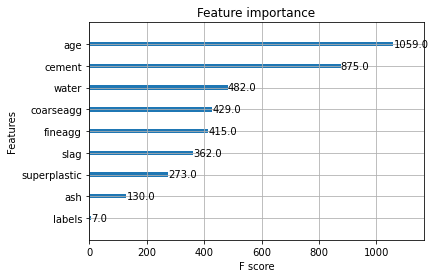

In [53]:
xgb = XGBRegressor()
xgb.fit(x,y)
xgboost.plot_importance(xgb)

In [54]:
x = new_df[['age','cement','water','coarseagg','fineagg','slag']]
y = new_df[['strength']]

In [55]:
cross_validation_tuned(x,y,fold=10)

,Model Name,Score mean,Score SD
8,XGboost regressor,0.904125,0.037433
7,G boost regressor,0.898147,0.050617
9,Random forest regressor,0.884241,0.036899
3,Decision Tree Regressor,0.823049,0.047527
6,ada boost regressor,0.735169,0.036272
1,Lasso,0.679542,0.061827
2,Ridge,0.679539,0.061858
0,Linear Regression,0.679539,0.061858
4,K nearest regressor,0.642410,0.060949
5,svr,0.261459,0.037619


## Generating Learning Curves

In [56]:
def generate_learning_curve(model_name, estimator,x,y, fold=10):
    train_size, train_score,test_score = learning_curve(estimator, x, y, cv=fold)
    train_score_mean = np.mean(train_score, axis=1)
    test_score_mean = np.mean(test_score, axis=1)
    plt.plot(train_size, train_score_mean, color = 'orange')
    plt.plot(train_size, test_score_mean, color = 'green')
    plt.xlabel('Samples')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve for '+ model_name)
    plt.legend(('train_score', 'test_score')) 

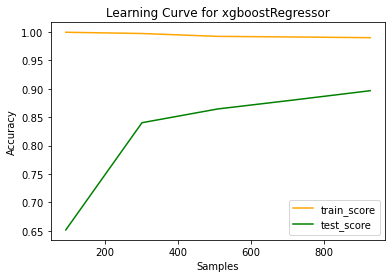

In [57]:
generate_learning_curve('xgboostRegressor', XGBRegressor(), x,y, fold=10)

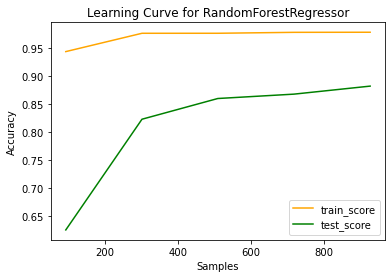

In [58]:
generate_learning_curve('RandomForestRegressor', RandomForestRegressor(), x,y, fold=10)